# Name: Nikshay Jain
# Roll Number: MM21B044
## Assign 8

In [23]:
import numpy as np
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_circles
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import accuracy_score
from sklearn.utils import resample

Dataset generation

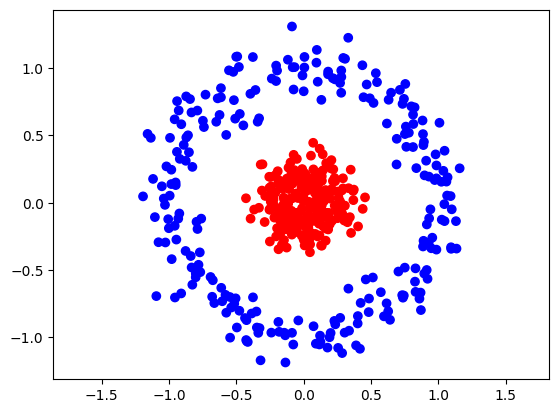

In [5]:
X, y = make_circles(n_samples=500, noise=0.1, random_state=42, factor=0.2) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 
plt.scatter(X[:,0], X[:,1], c=y, cmap=colors.ListedColormap(["blue", "red"])) 
plt.axis('equal') 
plt.show() 

Convert the y data to {-1,1} from {0,1}

In [6]:
y_train = np.where(y_train == 0, -1, 1)
y_test = np.where(y_test == 0, -1, 1)
print(y_train)
print(y_test)

[-1  1  1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1  1  1  1 -1 -1
 -1  1 -1 -1  1  1  1 -1  1 -1 -1 -1  1 -1 -1 -1  1  1 -1  1 -1  1  1 -1
 -1 -1  1 -1 -1  1 -1  1 -1  1  1  1 -1  1  1  1 -1  1  1 -1 -1  1 -1 -1
  1 -1  1 -1  1 -1  1  1  1 -1  1  1  1 -1 -1 -1  1  1 -1 -1 -1 -1 -1  1
  1  1 -1  1  1 -1 -1  1 -1  1  1  1  1 -1  1 -1  1  1  1  1 -1  1  1  1
 -1  1  1 -1  1 -1  1  1  1 -1  1  1  1  1 -1  1 -1  1 -1 -1 -1  1  1 -1
 -1  1 -1 -1 -1 -1 -1  1  1 -1  1  1 -1  1 -1  1  1 -1 -1 -1 -1 -1  1 -1
  1  1  1 -1 -1 -1  1  1  1  1 -1 -1  1 -1 -1 -1  1 -1  1  1  1  1 -1 -1
  1 -1  1  1 -1  1  1 -1  1 -1 -1  1 -1 -1 -1  1  1 -1  1 -1  1  1 -1  1
 -1 -1 -1  1  1  1 -1 -1 -1 -1 -1  1  1  1 -1  1  1 -1 -1  1 -1  1  1  1
 -1  1  1 -1 -1 -1  1  1 -1  1  1 -1 -1 -1  1 -1 -1  1  1 -1  1  1  1  1
 -1  1 -1 -1  1 -1 -1  1 -1  1  1  1 -1 -1  1 -1 -1  1 -1 -1  1 -1  1  1
 -1  1 -1  1  1  1 -1 -1  1  1  1 -1  1 -1 -1  1 -1  1 -1  1 -1 -1  1 -1
 -1  1  1 -1  1 -1  1 -1 -1  1  1 -1  1 -1 -1 -1 -1

## Task 1

In [68]:
# Function to plot the decision boundary
def plot_decision_boundary(predict_func, X, y, contour=True):
    x1s = np.linspace(-1.5, 1.5, 100)
    x2s = np.linspace(-1.5, 1.5, 100)
    x1, x2 = np.meshgrid(x1s, x2s)

    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = predict_func(X_new).reshape(x1.shape)

    custom_cmap = ListedColormap(['blue', 'red'])
    plt.contourf(x1, x2, y_pred, alpha=0.5, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['blue', 'red'])
        plt.contour(x1, x2, y_pred, alpha=0.5, cmap=custom_cmap2)
    
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "y.")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "b.")
    
    plt.xlabel("$X_1$")
    plt.ylabel("$X_2$")

Implement adaboost algo.

In [55]:
# Find the ensemble prediction given the classifier and the weights arrays.
def predict_ensemble(X, clasf, clf_wt):
    ensm_pred = np.zeros(X.shape[0])
    for clf, alpha in zip(clasf, clf_wt):
        ensm_pred += alpha * clf.predict(X)
    return ensm_pred

In [73]:
def adaboost(X_train, y_train, weak_clf, T, eta):
    n_samples = X_train.shape[0]
    sample_weights = np.ones(n_samples) / n_samples  # Initialize sample weights
    classifiers = []
    classifier_weights = []

    # Initialize the ensemble matrix to store F_t(x) at each iteration
    ensembles = np.zeros((T, X_train.shape[0]))

    for t in range(T):
        clf = clone(weak_clf)
        clf.fit(X_train, y_train, sample_weight=sample_weights)

        y_pred = clf.predict(X_train)

        misclassified = (y_pred != y_train)
        epsilon_t = np.dot(sample_weights, misclassified) / np.sum(sample_weights) # Error

        alpha_t = eta * np.log((1 - epsilon_t) / (epsilon_t + 1e-9))

        sample_weights *= np.exp(-alpha_t * y_train * y_pred)
        sample_weights /= np.sum(sample_weights)  # Normalize the weights

        # Store the classifier and its weight
        classifiers.append(clf)
        classifier_weights.append(alpha_t)

        # Call predict_ensemble and update the ensemble matrix
        F_t = predict_ensemble(X_train, classifiers, classifier_weights)
        ensembles[t] = F_t      # Store the cumulative ensemble prediction for this iteration

    return classifiers, classifier_weights, ensembles

Plot the classifier fit & the final decision boundary.

In [87]:
def plot_all_iterations(X, y, ensembles, classifiers, classifier_weights):
    x1s = np.linspace(-1.5, 1.5, 100)
    x2s = np.linspace(-1.5, 1.5, 100)
    x1, x2 = np.meshgrid(x1s, x2s)

    custom_cmap = ListedColormap(['blue','red'])
    X_new = np.c_[x1.ravel(), x2.ravel()]

    plt.contourf(x1, x2, np.zeros(x1.shape), alpha=0.5, cmap=custom_cmap)

    for t in range(ensembles.shape[0]):
        # Compute sign(F_t) at this iteration
        y_pred_t = np.sign(ensembles[t])
        y_pred_grid = np.sign(predict_ensemble(X_new, classifiers[:t+1], classifier_weights[:t+1])).reshape(x1.shape)

        plt.contour(x1, x2, y_pred_grid, cmap=custom_cmap, alpha=0.25)

    plt.plot(X[:, 0][y == -1], X[:, 1][y == -1], "b.", label="Class -1")
    plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], "r.", label="Class 1")
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")

## Task 2

### Logistic Regression

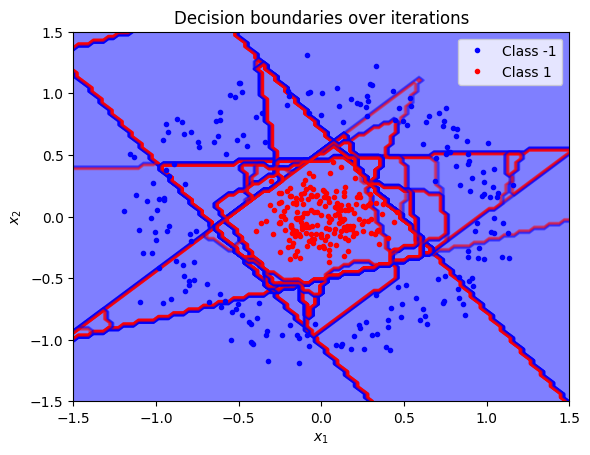

In [89]:
T_lr = 50    # Number of iterations
eta_lr = 0.59    # Learning Rate

# Logistic Regression as weak learner
logistic_regression = LogisticRegression(C=0.1, solver='liblinear')  # You can change 'liblinear' if needed

# Run Adaboost on the training data
classifiers_lr, classifier_weights_lr, ensembles_lr = adaboost(X_train, y_train, logistic_regression, T_lr, eta_lr)

# Plot decision boundaries over iterations
plt.title("Decision boundaries over iterations")
plot_all_iterations(X_train, y_train, ensembles_lr, classifiers_lr, classifier_weights_lr)

plt.legend()
plt.show()

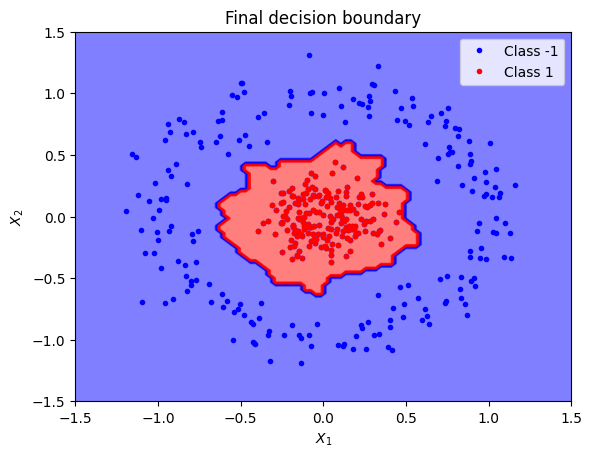

In [90]:
# Plot the final decision boundary
plt.title("Final decision boundary")
plot_decision_boundary(lambda X: np.sign(predict_ensemble(X, classifiers_lr, classifier_weights_lr)), X_train, y_train)

# Plot actual class points for both classes on the final decision boundary
plt.plot(X_train[:, 0][y_train == -1], X_train[:, 1][y_train == -1], "b.", label="Class -1")
plt.plot(X_train[:, 0][y_train == 1], X_train[:, 1][y_train == 1], "r.", label="Class 1")

plt.legend()
plt.show()

Final test accuracy for Logistic regr

In [61]:
y_test_pred_lr = np.sign(predict_ensemble(X_test, classifiers_lr, classifier_weights_lr))

# Calculate test accuracy
test_accuracy_lr = accuracy_score(y_test, y_test_pred_lr)
print(f"\n Test Accuracy (Logistic Regression): {test_accuracy_lr * 100:.2f}%")


 Test Accuracy (Logistic Regression): 100.00%


We can see that the running adaboost on logistic regression gives 100% test accuracy, and a nice decision boundary.

The hyperparameters used are - Number of iterations, Learning rate in AdaBoost, log regr regulariation hyperparameter

### Decision Stump

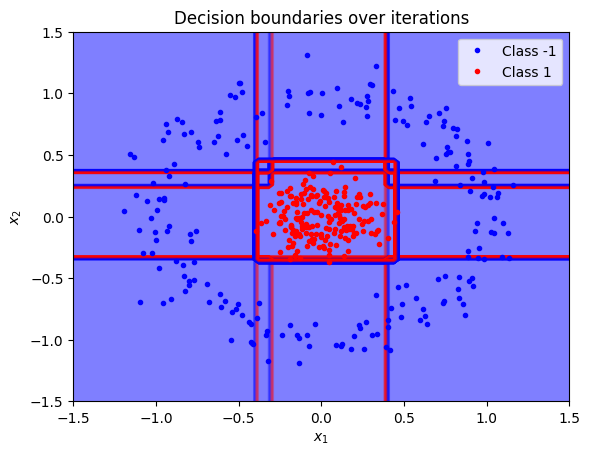

In [88]:
T_ds = 40  # Number of iterations
eta_ds = 0.5  # Learning Rate
decision_stump = DecisionTreeClassifier(max_depth=1)  # Decision stump as weak learner

# Run Adaboost on the training data
classifiers_ds, classifier_weights_ds, ensembles_ds = adaboost(X_train, y_train, decision_stump, T_ds, eta_ds)

# Plot decision boundaries over iterations
plt.title("Decision boundaries over iterations")
plot_all_iterations(X_train, y_train, ensembles_ds, classifiers_ds, classifier_weights_ds)
plt.legend()
plt.show()

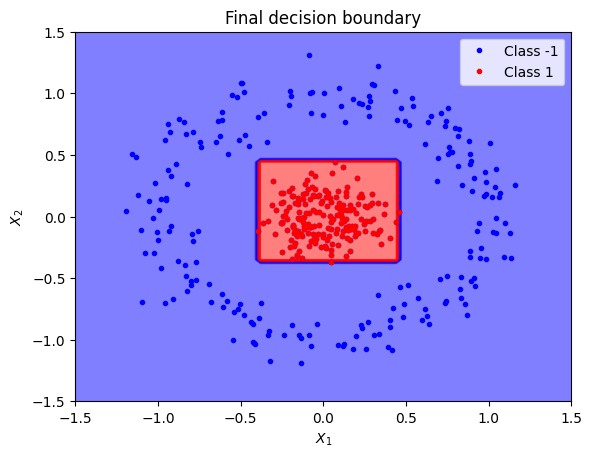

In [85]:
# Plot the final decision boundary
plt.title("Final decision boundary")
plot_decision_boundary(lambda X: np.sign(predict_ensemble(X, classifiers_ds, classifier_weights_ds)), X_train, y_train)

# Plot actual class points for both classes on the final decision boundary
plt.plot(X_train[:, 0][y_train == -1], X_train[:, 1][y_train == -1], "b.", label="Class -1")
plt.plot(X_train[:, 0][y_train == 1], X_train[:, 1][y_train == 1], "r.", label="Class 1")

plt.legend()
plt.show()

Final test accuracy for Decision stump

In [76]:
y_test_pred_ds = np.sign(predict_ensemble(X_test, classifiers_ds, classifier_weights_ds))

# Calculate test accuracy
test_accuracy_ds = accuracy_score(y_test, y_test_pred_ds)
print(f"\n Test Accuracy: {test_accuracy_ds * 100:.2f}%")


 Test Accuracy: 99.00%


We can notice that decision stump makes makes a rectangular decision boundary, and gives a good test accuracy of 99+% for the given hyperparameters.

The hyperparmeters used are - Number of iterations and Learning rate in AdaBoost

### Decision Tree (depth = 3)

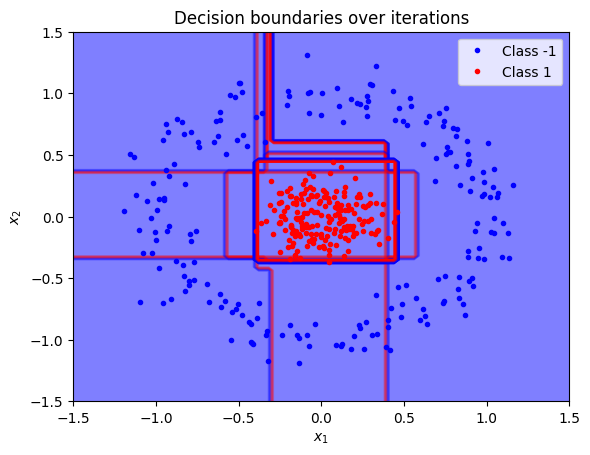

In [93]:
T_dt = 11  # Number of iterations
eta_dt = 0.5  # Learning Rate

decision_tree = DecisionTreeClassifier(max_depth=3, min_samples_split=2, min_samples_leaf=3, random_state=42)

# Run Adaboost on the training data
classifiers_dt, classifier_weights_dt, ensembles_dt = adaboost(X_train, y_train, decision_tree, T_dt, eta_dt)

# Plot decision boundaries over iterations
plt.title("Decision boundaries over iterations")
plot_all_iterations(X_train, y_train, ensembles_dt, classifiers_dt, classifier_weights_dt)
plt.legend()
plt.show()

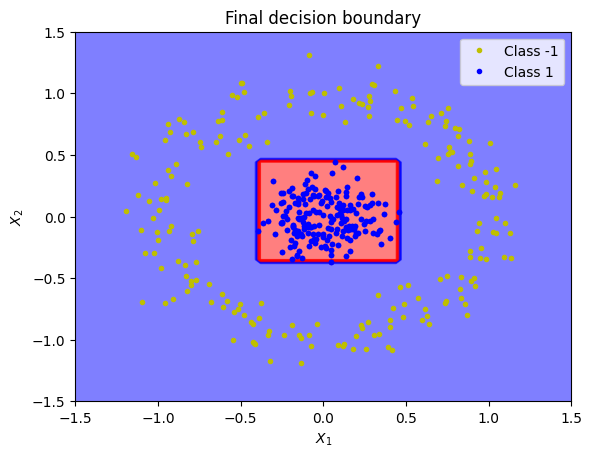

In [92]:
# Plot the final decision boundary
plt.title("Final decision boundary")
plot_decision_boundary(lambda X: np.sign(predict_ensemble(X, classifiers_dt, classifier_weights_dt)), X_train, y_train)

# Plot actual class points for both classes on the final decision boundary
plt.plot(X_train[:, 0][y_train == -1], X_train[:, 1][y_train == -1], "y.", label="Class -1")
plt.plot(X_train[:, 0][y_train == 1], X_train[:, 1][y_train == 1], "b.", label="Class 1")

plt.legend()
plt.show()

Final test accuracy for decision tree

In [91]:
y_test_pred_dt = np.sign(predict_ensemble(X_test, classifiers_dt, classifier_weights_dt))

# Calculate test accuracy
test_accuracy_dt = accuracy_score(y_test, y_test_pred_dt)
print(f"\n Test Accuracy: {test_accuracy_dt * 100:.2f}%")


 Test Accuracy: 99.00%


The decision boundary and test accuracy decision tree of depth 3 are the same as those obtained with a decision stump.

The hyperparameters used are as follows - Number of iterations, Learning rate, min_samples_split, min_samples_leaf = 3

### Linear SVM

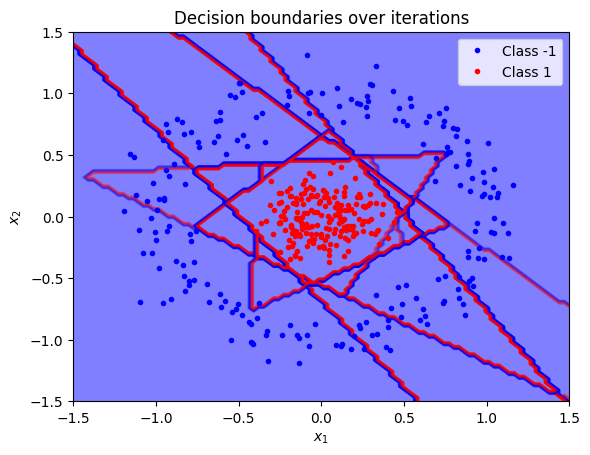

In [97]:
T_svm = 20  # Number of iterations
eta_svm = 0.6  # Learning Rate

# Create Linear SVM model (you can modify C and kernel hyperparameters)
linear_svm = SVC(kernel='linear', C=100, random_state=42)

# Run Adaboost on the training data
classifiers_svm, classifier_weights_svm, ensembles_svm = adaboost(X_train, y_train, linear_svm, T_svm, eta_svm)

# Plot decision boundaries over iterations (left plot)
plt.title("Decision boundaries over iterations")
plot_all_iterations(X_train, y_train, ensembles_svm, classifiers_svm, classifier_weights_svm)

plt.legend()
plt.show()

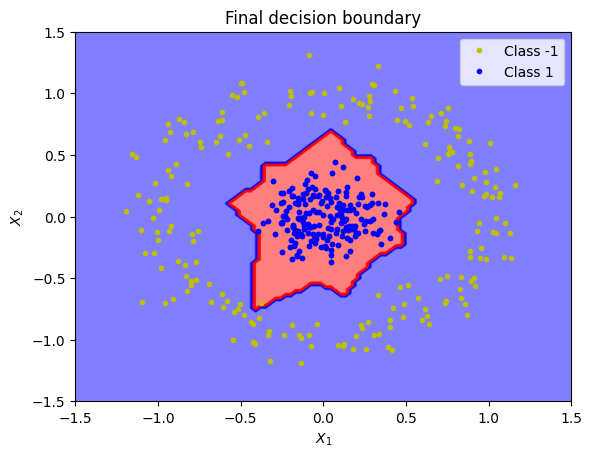

In [96]:
# Plot the final decision boundary (right plot)
plt.title("Final decision boundary")
plot_decision_boundary(lambda X: np.sign(predict_ensemble(X, classifiers_svm, classifier_weights_svm)), X_train, y_train)

# Plot actual class points for both classes on the final decision boundary
plt.plot(X_train[:, 0][y_train == -1], X_train[:, 1][y_train == -1], "y.", label="Class -1")
plt.plot(X_train[:, 0][y_train == 1], X_train[:, 1][y_train == 1], "b.", label="Class 1")

plt.legend()
plt.show()

Final test accuracy for SVC

In [94]:
y_test_pred_svm = np.sign(predict_ensemble(X_test, classifiers_svm, classifier_weights_svm))

# Calculate test accuracy
test_accuracy_svm = accuracy_score(y_test, y_test_pred_svm)
print(f"\n Test Accuracy: {test_accuracy_svm * 100:.2f}%")


 Test Accuracy: 100.00%


We get a good decision boundary giving a 100% test accuracy for the given hyperparameters.

The hyperparameters used are as follows - Number of iterations, Learning rate in AdaBoost, SVM regularizartion parametes

### Linear Discriminant Analysis (LDA)

In [114]:
def adaboost_resample(X_train, y_train, weak_clf, T, eta):
    n_samples = X_train.shape[0]
    sample_weights = np.ones(n_samples) / n_samples  # Initialize sample weights
    classifiers = []
    classifier_weights = []

    # Initialize the ensemble matrix to store F_t(x) at each iteration
    ensembles = np.zeros((T, X_train.shape[0]))

    for t in range(T):
        # Clone the weak classifier to avoid overwriting
        clf = clone(weak_clf)

        # Weighted resampling using np.random.choice
        indices = np.random.choice(np.arange(n_samples), size=n_samples, replace=True, p=sample_weights)
        X_resampled = X_train[indices]
        y_resampled = y_train[indices]

        # Train the classifier on the resampled data
        clf.fit(X_resampled, y_resampled)

        # Predict on the original training data
        y_pred = clf.predict(X_train)

        # Compute the error rate
        misclassified = (y_pred != y_train)
        epsilon_t = np.dot(sample_weights, misclassified) / np.sum(sample_weights)  # Error

        # Compute the classifier weight
        alpha_t = eta * np.log((1 - epsilon_t) / (epsilon_t + 1e-9))

        # Weight update step
        sample_weights *= np.exp(-alpha_t * y_train * y_pred)
        sample_weights /= np.sum(sample_weights)  # Normalize the weights

        # Store the classifier and its weight
        classifiers.append(clf)
        classifier_weights.append(alpha_t)

        # Call predict_ensemble and update the ensemble matrix
        F_t = predict_ensemble(X_train, classifiers, classifier_weights)
        ensembles[t] = F_t  # Store the cumulative ensemble prediction for this iteration

    return classifiers, classifier_weights, ensembles

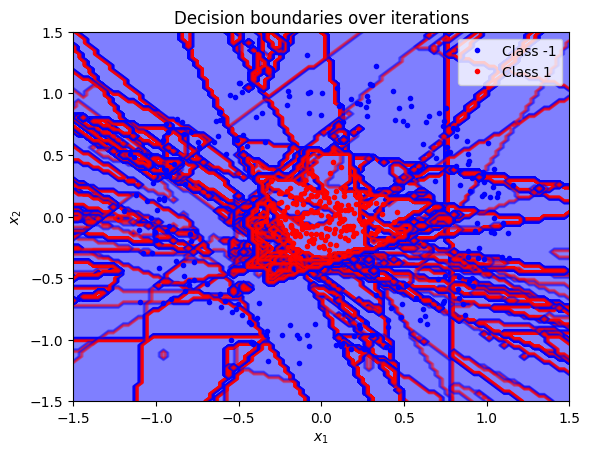

In [118]:
T_lda = 190 # Number of iterations
eta_lda = 0.8 # Learning Rate
lda_model = LDA()  # LDA as weak learner

# Run Adaboost on the training data with LDA
classifiers_lda, classifier_weights_lda, ensembles_lda = adaboost_resample(X_train, y_train, lda_model, T_lda, eta_lda)

# Plot decision boundaries over iterations
plt.title("Decision boundaries over iterations")
plot_all_iterations(X_train, y_train, ensembles_lda, classifiers_lda, classifier_weights_lda)

plt.legend()
plt.show()

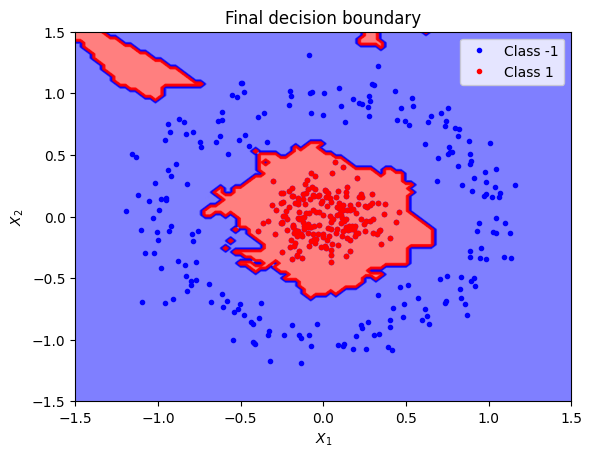

In [116]:
# Plot the final decision boundary
plt.title("Final decision boundary")
plot_decision_boundary(lambda X: np.sign(predict_ensemble(X, classifiers_lda, classifier_weights_lda)), X_train, y_train)

# Plot actual class points for both classes on the final decision boundary
plt.plot(X_train[:, 0][y_train == -1], X_train[:, 1][y_train == -1], "b.", label="Class -1")
plt.plot(X_train[:, 0][y_train == 1], X_train[:, 1][y_train == 1], "r.", label="Class 1")

plt.legend()
plt.show()

Final test accuracy for LDA

In [117]:
y_test_pred_lda = np.sign(predict_ensemble(X_test, classifiers_lda, classifier_weights_lda))

# Calculate test accuracy
test_accuracy_lda = accuracy_score(y_test, y_test_pred_lda)
print(f"\n Test Accuracy: {test_accuracy_lda * 100:.2f}%")


 Test Accuracy: 100.00%


LDA model wtih adaboost has given 100% test accuracy at the given hyperparameters

The hyperparameters used are - Number of iterations, Learning rate.

The number of iterations is higher for LDA compared to the other 5 weak
classifiers.

Decision tree with depth 3 took the least amount of iterations.